In [12]:
# PACKAGE IMPORT
from torch import nn
from torchsummary import summary
import torch
import torchvision.transforms as tt
from torch.utils.data import Dataset, DataLoader, random_split
from numpy import array, random, genfromtxt, shape, zeros, ones, amin, amax, savetxt, linspace, flipud, fliplr
import numpy as np
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import cv2

# VISUALIZATION PACKAGES
import skimage.data as data
import skimage.segmentation as seg
import skimage.filters as filters
import skimage.draw as draw
import skimage.color as color

In [2]:
# DATA LOADER CLASS
class MyDataset(Dataset):
    def __init__(self, data, targets):
        self.dataTemp    = torch.FloatTensor(data)
        self.targetsTemp = torch.LongTensor(targets)
        self.data        = self.dataTemp.cuda()
        self.targets     = self.targetsTemp.cuda()
        
        #self.targets.requires_grad_(True)

    def __getitem__(self, index):
        x = self.data[index]
        y = self.targets[index]
        return x, y

    def __len__(self):
        return len(self.data)

# Unet++ (Nested Unet) ARCHITECTURE
class conv_block_nested(nn.Module):
    
    def __init__(self, in_ch, mid_ch, out_ch):
        super(conv_block_nested, self).__init__()
        self.activation = nn.LeakyReLU(inplace=True)
        self.conv1 = nn.Conv2d(in_ch, mid_ch, kernel_size=3, padding=1, bias=True)
        self.bn1 = nn.BatchNorm2d(mid_ch)
        self.conv2 = nn.Conv2d(mid_ch, out_ch, kernel_size=3, padding=1, bias=True)
        self.bn2 = nn.BatchNorm2d(out_ch)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.activation(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        output = self.activation(x)

        return output
    
#Nested Unet

class NestedUNet(nn.Module):
    """
    Implementation of this paper:
    https://arxiv.org/pdf/1807.10165.pdf
    """
    def __init__(self, in_ch=3, out_ch=1):
        super(NestedUNet, self).__init__()

        n1 =32
        filters = [n1, n1 * 2, n1 * 4, n1 * 8, n1 * 16]

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.Up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        self.conv0_0 = conv_block_nested(in_ch, filters[0], filters[0])
        self.conv1_0 = conv_block_nested(filters[0], filters[1], filters[1])
        self.conv2_0 = conv_block_nested(filters[1], filters[2], filters[2])
        self.conv3_0 = conv_block_nested(filters[2], filters[3], filters[3])
        self.conv4_0 = conv_block_nested(filters[3], filters[4], filters[4])

        self.conv0_1 = conv_block_nested(filters[0] + filters[1], filters[0], filters[0])
        self.conv1_1 = conv_block_nested(filters[1] + filters[2], filters[1], filters[1])
        self.conv2_1 = conv_block_nested(filters[2] + filters[3], filters[2], filters[2])
        self.conv3_1 = conv_block_nested(filters[3] + filters[4], filters[3], filters[3])

        self.conv0_2 = conv_block_nested(filters[0]*2 + filters[1], filters[0], filters[0])
        self.conv1_2 = conv_block_nested(filters[1]*2 + filters[2], filters[1], filters[1])
        self.conv2_2 = conv_block_nested(filters[2]*2 + filters[3], filters[2], filters[2])

        self.conv0_3 = conv_block_nested(filters[0]*3 + filters[1], filters[0], filters[0])
        self.conv1_3 = conv_block_nested(filters[1]*3 + filters[2], filters[1], filters[1])

        self.conv0_4 = conv_block_nested(filters[0]*4 + filters[1], filters[0], filters[0])

        self.final = nn.Conv2d(filters[0], out_ch, kernel_size=1)


    def forward(self, x):
        
        x0_0 = self.conv0_0(x)
        x1_0 = self.conv1_0(self.pool(x0_0))
        x0_1 = self.conv0_1(torch.cat([x0_0, self.Up(x1_0)], 1))

        x2_0 = self.conv2_0(self.pool(x1_0))
        x1_1 = self.conv1_1(torch.cat([x1_0, self.Up(x2_0)], 1))
        x0_2 = self.conv0_2(torch.cat([x0_0, x0_1, self.Up(x1_1)], 1))

        x3_0 = self.conv3_0(self.pool(x2_0))
        x2_1 = self.conv2_1(torch.cat([x2_0, self.Up(x3_0)], 1))
        x1_2 = self.conv1_2(torch.cat([x1_0, x1_1, self.Up(x2_1)], 1))
        x0_3 = self.conv0_3(torch.cat([x0_0, x0_1, x0_2, self.Up(x1_2)], 1))

        x4_0 = self.conv4_0(self.pool(x3_0))
        x3_1 = self.conv3_1(torch.cat([x3_0, self.Up(x4_0)], 1))
        x2_2 = self.conv2_2(torch.cat([x2_0, x2_1, self.Up(x3_1)], 1))
        x1_3 = self.conv1_3(torch.cat([x1_0, x1_1, x1_2, self.Up(x2_2)], 1))
        x0_4 = self.conv0_4(torch.cat([x0_0, x0_1, x0_2, x0_3, self.Up(x1_3)], 1))

        output = self.final(x0_4)
        return output


class NestedUNetLevel_3(nn.Module):
    """
    Implementation of this paper:
    https://arxiv.org/pdf/1807.10165.pdf
    """
    def __init__(self, in_ch=5, out_ch=1):
        super(NestedUNetLevel_3, self).__init__()

        n1 = 32
        filters = [n1, n1 * 2, n1 * 4, n1 * 8, n1 * 16]

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.Up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        self.conv0_0 = conv_block_nested(in_ch, filters[0], filters[0])
        self.conv1_0 = conv_block_nested(filters[0], filters[1], filters[1])
        self.conv2_0 = conv_block_nested(filters[1], filters[2], filters[2])
        self.conv3_0 = conv_block_nested(filters[2], filters[3], filters[3])

        self.conv0_1 = conv_block_nested(filters[0] + filters[1], filters[0], filters[0])
        self.conv1_1 = conv_block_nested(filters[1] + filters[2], filters[1], filters[1])
        self.conv2_1 = conv_block_nested(filters[2] + filters[3], filters[2], filters[2])

        self.conv0_2 = conv_block_nested(filters[0]*2 + filters[1], filters[0], filters[0])
        self.conv1_2 = conv_block_nested(filters[1]*2 + filters[2], filters[1], filters[1])

        self.conv0_3 = conv_block_nested(filters[0]*3 + filters[1], filters[0], filters[0])

        self.final = nn.Conv2d(filters[0], out_ch, kernel_size=1)


    def forward(self, x):
        
        x0_0 = self.conv0_0(x)
        x1_0 = self.conv1_0(self.pool(x0_0))
        x0_1 = self.conv0_1(torch.cat([x0_0, self.Up(x1_0)], 1))

        x2_0 = self.conv2_0(self.pool(x1_0))
        x1_1 = self.conv1_1(torch.cat([x1_0, self.Up(x2_0)], 1))
        x0_2 = self.conv0_2(torch.cat([x0_0, x0_1, self.Up(x1_1)], 1))

        x3_0 = self.conv3_0(self.pool(x2_0))
        x2_1 = self.conv2_1(torch.cat([x2_0, self.Up(x3_0)], 1))
        x1_2 = self.conv1_2(torch.cat([x1_0, x1_1, self.Up(x2_1)], 1))
        x0_3 = self.conv0_3(torch.cat([x0_0, x0_1, x0_2, self.Up(x1_2)], 1))

        output = self.final(x0_3)
        return output

class NestedUNetLevel_2(nn.Module):
    """
    Implementation of this paper:
    https://arxiv.org/pdf/1807.10165.pdf
    """
    def __init__(self, in_ch=6, out_ch=1):
        super(NestedUNetLevel_2, self).__init__()

        n1 = 16
        filters = [n1, n1 * 2, n1 * 4, n1 * 8, n1 * 16]

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.Up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        self.conv0_0 = conv_block_nested(in_ch, filters[0], filters[0])
        self.conv1_0 = conv_block_nested(filters[0], filters[1], filters[1])
        self.conv2_0 = conv_block_nested(filters[1], filters[2], filters[2])

        self.conv0_1 = conv_block_nested(filters[0] + filters[1], filters[0], filters[0])
        self.conv1_1 = conv_block_nested(filters[1] + filters[2], filters[1], filters[1])

        self.conv0_2 = conv_block_nested(filters[0]*2 + filters[1], filters[0], filters[0])

        self.final = nn.Conv2d(filters[0], out_ch, kernel_size=1)


    def forward(self, x):
        
        x0_0 = self.conv0_0(x)
        x1_0 = self.conv1_0(self.pool(x0_0))
        x0_1 = self.conv0_1(torch.cat([x0_0, self.Up(x1_0)], 1))

        x2_0 = self.conv2_0(self.pool(x1_0))
        x1_1 = self.conv1_1(torch.cat([x1_0, self.Up(x2_0)], 1))
        x0_2 = self.conv0_2(torch.cat([x0_0, x0_1, self.Up(x1_1)], 1))

        output = self.final(x0_2)
        return output    
    
#Dictioary Unet
#if required for getting the filters and model parameters for each step 

class ConvolutionBlock(nn.Module):
    """Convolution block"""

    def __init__(self, in_filters, out_filters, kernel_size=3, batchnorm=True, last_active=F.relu):
        super(ConvolutionBlock, self).__init__()

        self.bn = batchnorm
        self.last_active = last_active
        self.c1 = nn.Conv2d(in_filters, out_filters, kernel_size, padding=1)
        self.b1 = nn.BatchNorm2d(out_filters)
        self.c2 = nn.Conv2d(out_filters, out_filters, kernel_size, padding=1)
        self.b2 = nn.BatchNorm2d(out_filters)

    def forward(self, x):
        x = self.c1(x)
        if self.bn:
            x = self.b1(x)
        x = F.relu(x)
        x = self.c2(x)
        if self.bn:
            x = self.b2(x)
        x = self.last_active(x)
        return x


class ContractiveBlock(nn.Module):
    """Deconvuling Block"""

    def __init__(self, in_filters, out_filters, conv_kern=3, pool_kern=2, dropout=0.5, batchnorm=True):
        super(ContractiveBlock, self).__init__()
        self.c1 = ConvolutionBlock(in_filters=in_filters, out_filters=out_filters, kernel_size=conv_kern,
                                   batchnorm=batchnorm)
        self.p1 = nn.MaxPool2d(kernel_size=pool_kern, ceil_mode=True)
        self.d1 = nn.Dropout2d(dropout)

    def forward(self, x):
        c = self.c1(x)
        return c, self.d1(self.p1(c))


class ExpansiveBlock(nn.Module):
    """Upconvole Block"""

    def __init__(self, in_filters1, in_filters2, out_filters, tr_kern=3, conv_kern=3, stride=2, dropout=0.5):
        super(ExpansiveBlock, self).__init__()
        self.t1 = nn.ConvTranspose2d(in_filters1, out_filters, tr_kern, stride=2, padding=1, output_padding=1)
        self.d1 = nn.Dropout(dropout)
        self.c1 = ConvolutionBlock(out_filters + in_filters2, out_filters, conv_kern)

    def forward(self, x, contractive_x):
        x_ups = self.t1(x)
        x_concat = torch.cat([x_ups, contractive_x], 1)
        x_fin = self.c1(self.d1(x_concat))
        return x_fin


class Unet_dict(nn.Module):
    """Unet which operates with filters dictionary values"""

    def __init__(self, n_labels, n_filters=32, p_dropout=0.5, batchnorm=True):
        super(Unet_dict, self).__init__()
        filters_dict = {}
        filt_pair = [3, n_filters]

        for i in range(4):
            self.add_module('contractive_' + str(i), ContractiveBlock(filt_pair[0], filt_pair[1], batchnorm=batchnorm))
            filters_dict['contractive_' + str(i)] = (filt_pair[0], filt_pair[1])
            filt_pair[0] = filt_pair[1]
            filt_pair[1] = filt_pair[1] * 2

        self.bottleneck = ConvolutionBlock(filt_pair[0], filt_pair[1], batchnorm=batchnorm)
        filters_dict['bottleneck'] = (filt_pair[0], filt_pair[1])

        for i in reversed(range(4)):
            self.add_module('expansive_' + str(i),
                            ExpansiveBlock(filt_pair[1], filters_dict['contractive_' + str(i)][1], filt_pair[0]))
            filters_dict['expansive_' + str(i)] = (filt_pair[1], filt_pair[0])
            filt_pair[1] = filt_pair[0]
            filt_pair[0] = filt_pair[0] // 2

        self.output = nn.Conv2d(filt_pair[1], n_labels, kernel_size=1)
        filters_dict['output'] = (filt_pair[1], n_labels)
        self.filters_dict = filters_dict

    # final_forward
    def forward(self, x):
        c00, c0 = self.contractive_0(x)
        c11, c1 = self.contractive_1(c0)
        c22, c2 = self.contractive_2(c1)
        c33, c3 = self.contractive_3(c2)
        bottle = self.bottleneck(c3)
        u3 = F.relu(self.expansive_3(bottle, c33))
        u2 = F.relu(self.expansive_2(u3, c22))
        u1 = F.relu(self.expansive_1(u2, c11))
        u0 = F.relu(self.expansive_0(u1, c00))
        return F.softmax(self.output(u0), dim=1)

In [3]:
# Device Check
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
#device = torch.device('cpu')
print(device)

cuda


In [4]:
# IoU SCORE CALCULATION
def IoU(target, prediction):
    intersection  = np.logical_and(target, prediction)
    union         = np.logical_or(target, prediction)
    iou_score     = np.sum(intersection) / np.sum(union)
    return iou_score

In [6]:
# IoU CALCULATION

'''
You can access test data using the below link:
https://drive.google.com/drive/folders/1h7rkcmIvJxr4TPT4_eUbxXLPELJFODSd?usp=sharing
'''

testDLname   = 'TEST_DATA_80X80.pth'
test_dl      = torch.load(testDLname)

numModel = 5

for k in range(numModel):
    modelName    = "TEST_UNET_PLUSPLUS_MODEL_" + str(int(k+1))+ ".pt"
    model        = torch.load(modelName)
    iterNum      = 80
    numBatch     = 50
    it           = iter(test_dl)
    iouScoreList = []

    for i in range(iterNum):
        xb, yb = next(it)
        with torch.no_grad():
            ybPredict = model(xb)     
        # Post Processing
        out_softmax = torch.softmax(ybPredict, dim=1)
        outputNew   = torch.argmax(out_softmax, dim=1)
        outputNew   = outputNew.cpu().numpy()
        outputNew   = np.squeeze(outputNew)
        # Ground Truth
        groundTruth = yb.cpu().numpy()
        for j in range(numBatch):
            ind             = i*50 + j
            iou_score = IoU(groundTruth[j], outputNew[j])
            iouScoreList.append(iou_score)
    
    iouScoreName = 'IoU_UNET_PLUSPLUS_' + str(int(k+1)) + '.dat'
    denData      = savetxt(iouScoreName,  iouScoreList,  fmt='%2.5e', delimiter='\t')

In [9]:
#VISUALIZATION
def image_show(image, nrows=1, ncols=1, cmap='gray'):
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 15))
    ax.imshow(image, alpha=0.7, cmap='Blues')
    ax.axis('off')
    return fig, ax

In [25]:
iterNum      = 5
it           = iter(test_dl)
iouScoreList = []

xb, yb = next(it)
    
with torch.no_grad():
    ybPredict = model(xb)     

out_softmax = torch.softmax(ybPredict, dim=1)
outputNew   = torch.argmax(out_softmax, dim=1)
outputNew   = outputNew.cpu().numpy()
outputNew   = np.squeeze(outputNew)

groundTruth = yb.cpu().numpy()

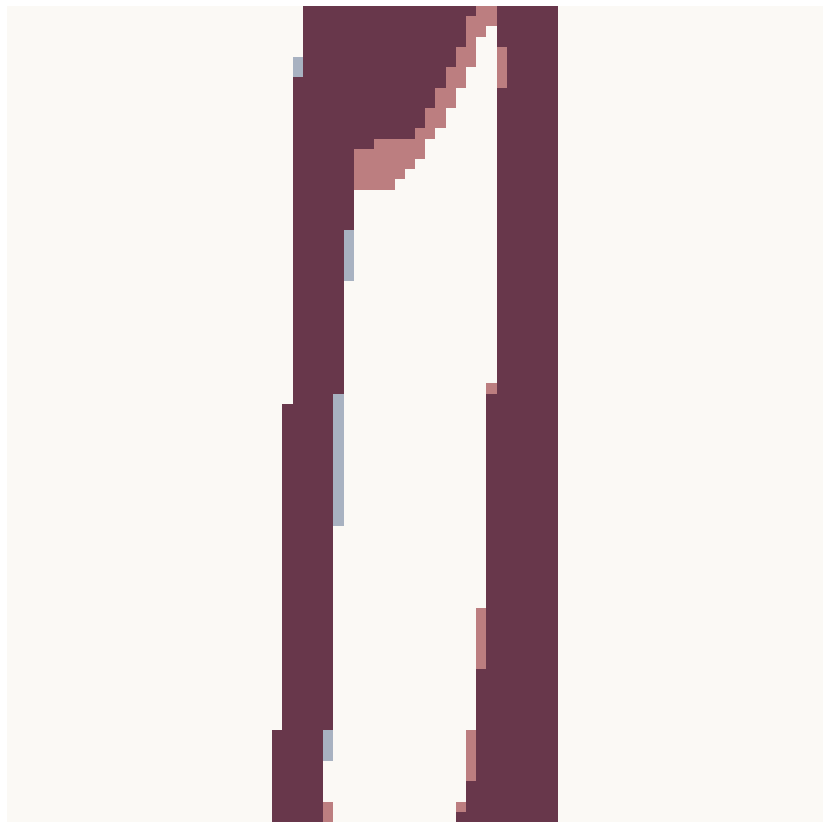

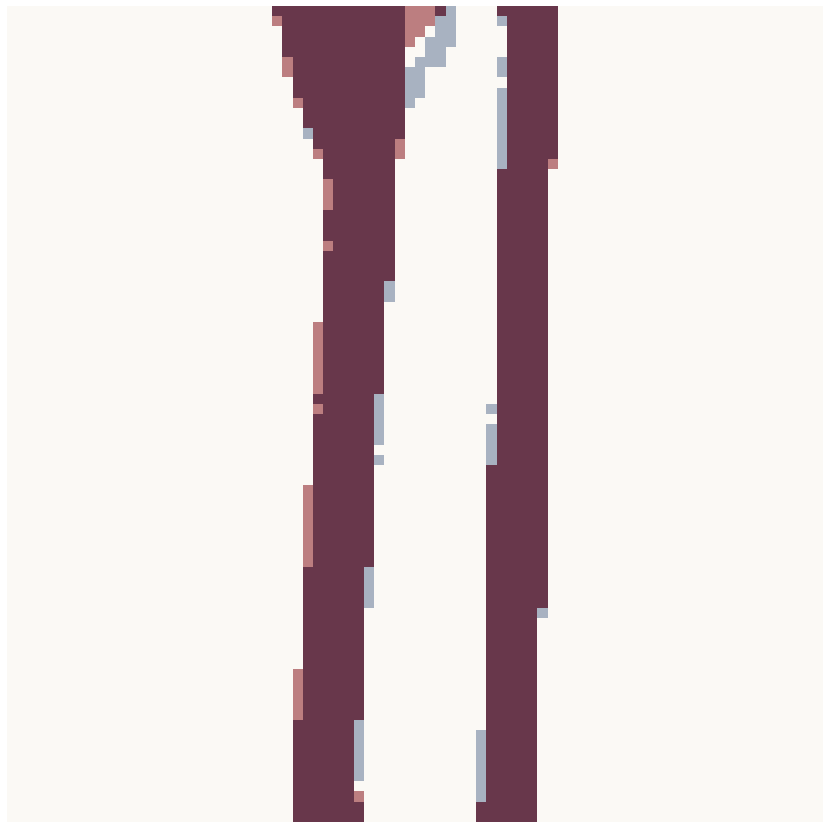

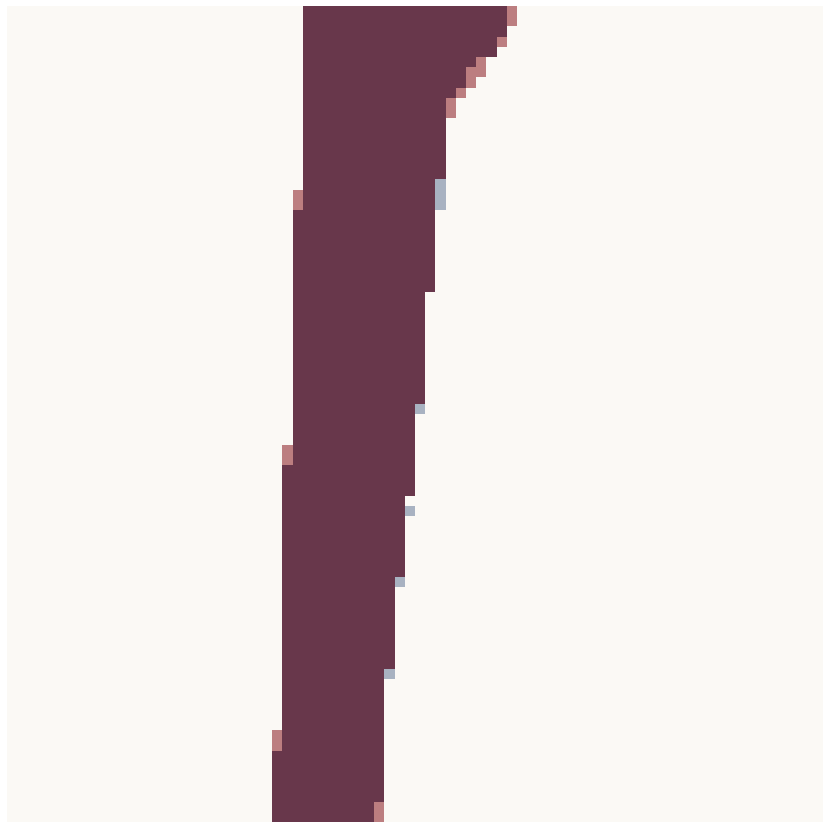

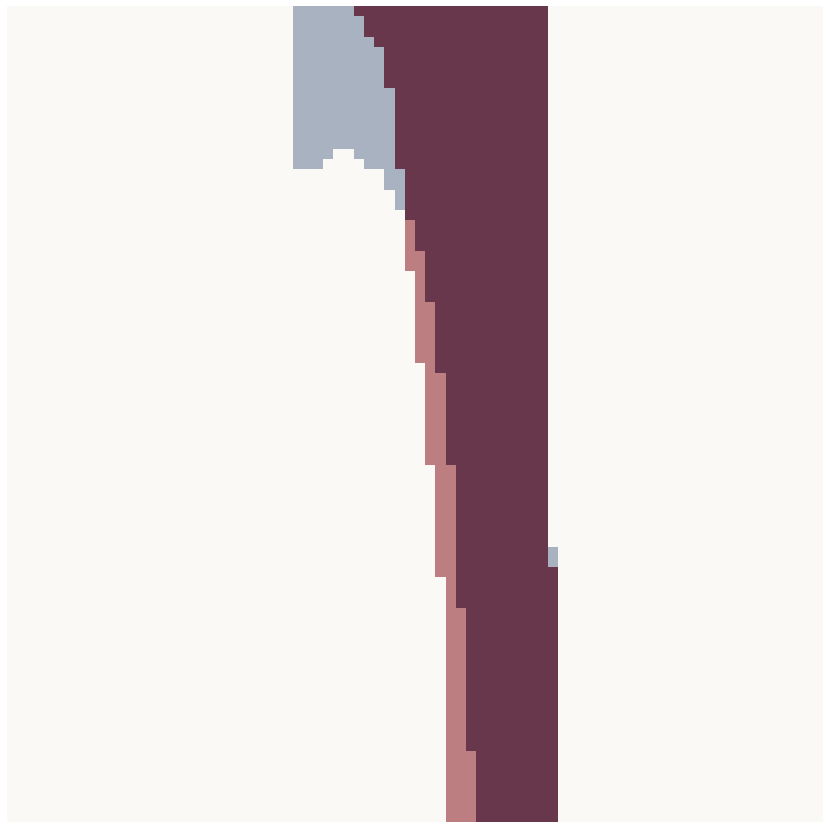

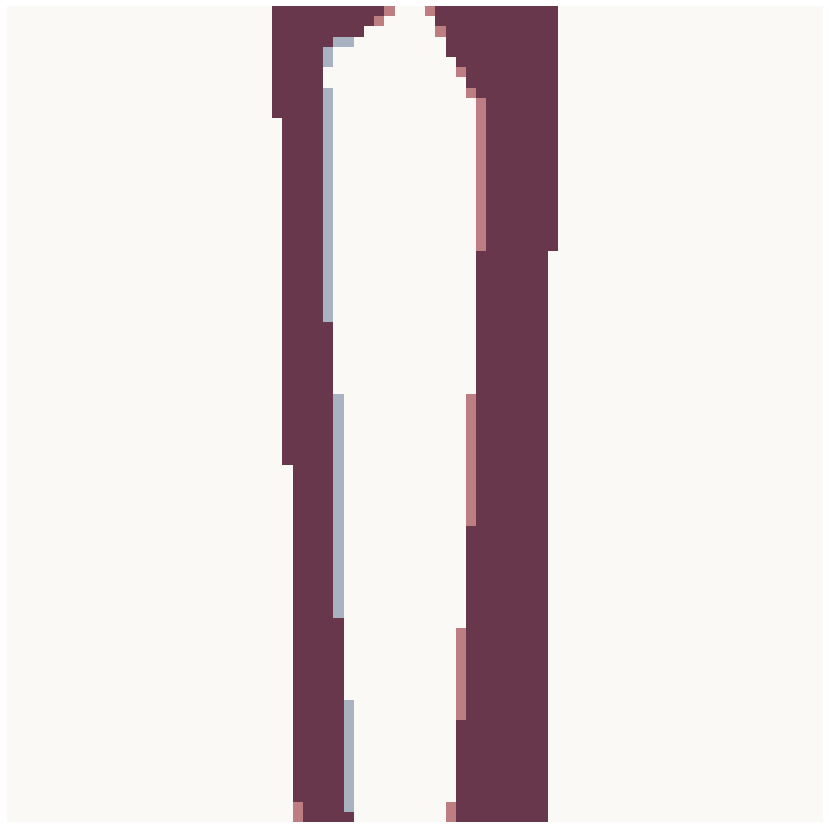

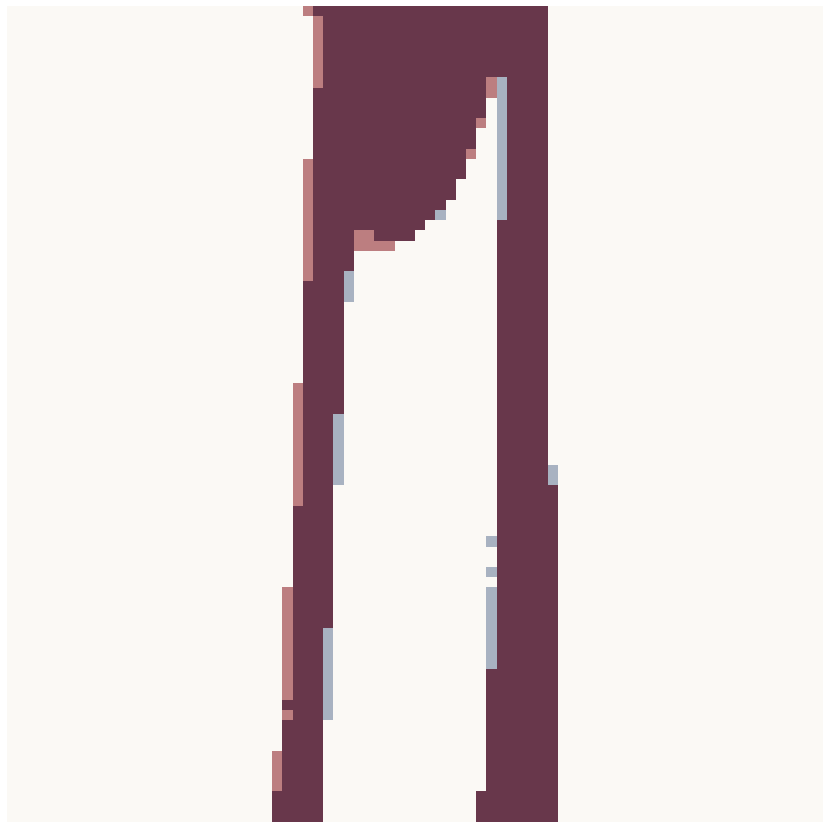

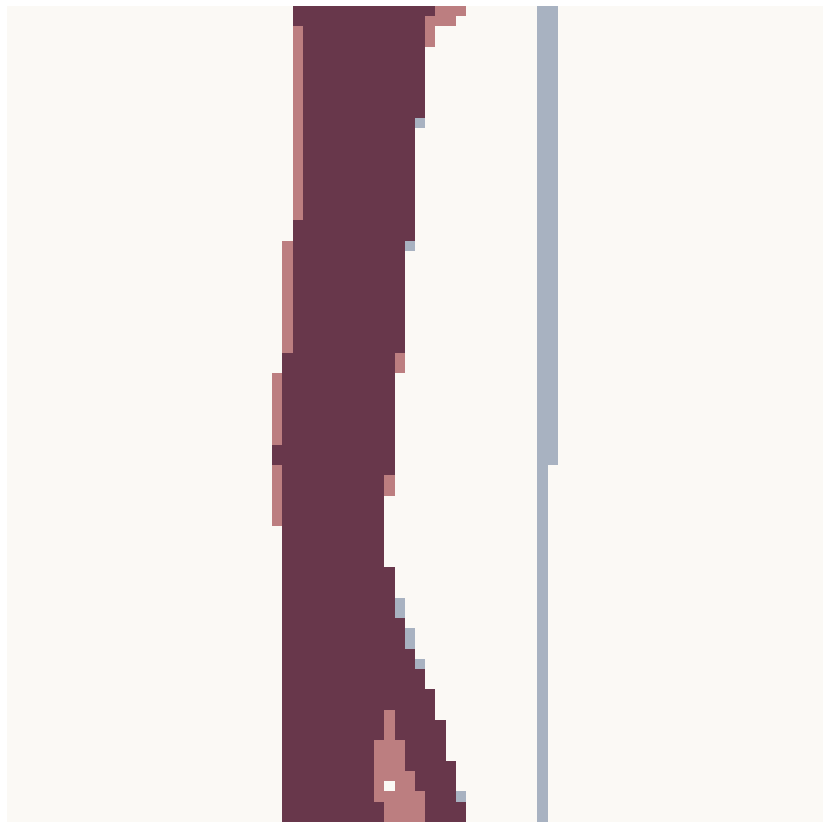

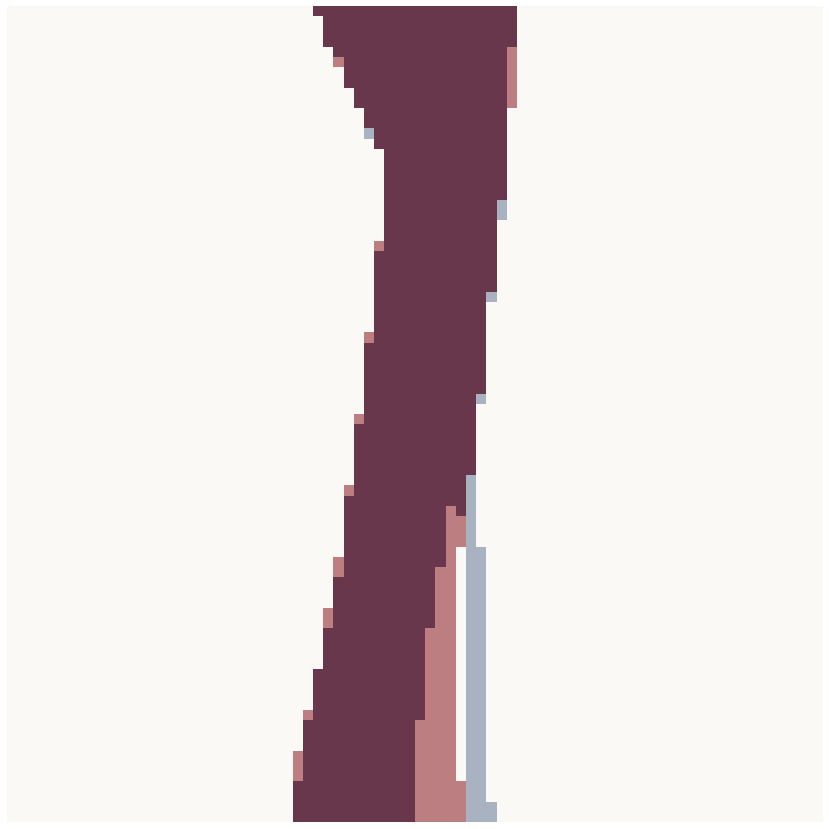

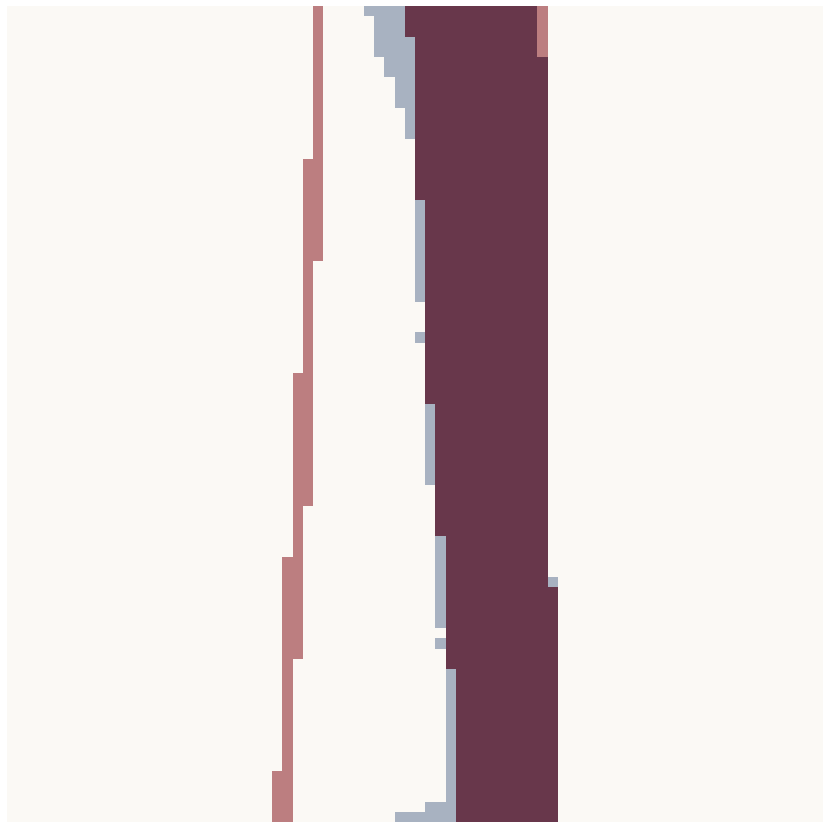

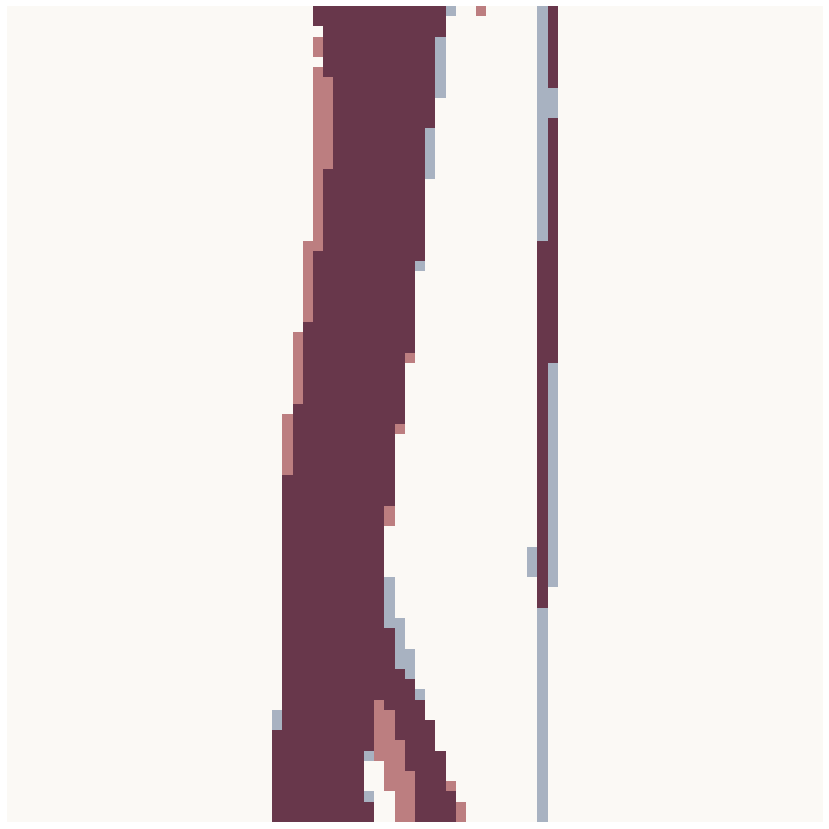

In [26]:
#VISUALIZATION
modelName = 'TEST_MODEL_5'
idxList   = [1,4,5,12,19,20,25,30,41,44]

for i in range(10):
    idx = idxList[i]
    image_segmented = seg.random_walker(flipud(groundTruth[idx]), flipud(outputNew[idx]), beta = 3000)
    figName = modelName + '_' +str(i+1) + '.png'
    fig, ax = image_show(flipud(groundTruth[idx]))
    ax.imshow(flipud(outputNew[idx]) == 1, alpha=0.5, cmap='OrRd')
    fig.savefig(figName, dpi = 300)